In [1]:
import os, shutil

In [4]:
home_dir = os.getcwd()
file_path = os.path.join(home_dir, 'dataset')

original_with_muzzle_dir = os.path.join(file_path, 'Dog face with muzzle')
original_without_muzzle_dir = os.path.join(file_path, 'Dog face')

In [5]:
# 훈련, 검증, 테스트 디렉토리 생성

train_dir = os.path.join(file_path, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(file_path, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(file_path, 'test')
os.mkdir(test_dir)

In [6]:
# 훈련, 검증, 테스트 디렉토리에 입마개 착용/미착용 디렉토리 생성

train_with_muzzle_dir = os.path.join(train_dir, 'with muzzle')
os.mkdir(train_with_muzzle_dir)

train_without_muzzle_dir = os.path.join(train_dir, 'without muzzle')
os.mkdir(train_without_muzzle_dir)

validation_with_muzzle_dir = os.path.join(validation_dir, 'with muzzle')
os.mkdir(validation_with_muzzle_dir)

validation_without_muzzle_dir = os.path.join(validation_dir, 'without muzzle')
os.mkdir(validation_without_muzzle_dir)

test_with_muzzle_dir = os.path.join(test_dir, 'with muzzle')
os.mkdir(test_with_muzzle_dir)

test_without_muzzle_dir = os.path.join(test_dir, 'without muzzle')
os.mkdir(test_without_muzzle_dir)

In [7]:
train_num = int(len(os.listdir(original_with_muzzle_dir)) * 0.6)
validation_num = int(len(os.listdir(original_with_muzzle_dir)) * 0.8)

In [8]:
with_muzzle_fnames = os.listdir(original_with_muzzle_dir)
without_muzzle_fnames = os.listdir(original_without_muzzle_dir)

In [9]:
# 훈련, 검증, 테스트 데이터 생성

for fname in with_muzzle_fnames[:train_num]:
    src = os.path.join(original_with_muzzle_dir, fname)
    dst = os.path.join(train_with_muzzle_dir, fname)
    shutil.copy(src, dst)

for fname in without_muzzle_fnames[:train_num]:
    src = os.path.join(original_without_muzzle_dir, fname)
    dst = os.path.join(train_without_muzzle_dir, fname)
    shutil.copy(src, dst) 

    
for fname in with_muzzle_fnames[train_num:validation_num]:
    src = os.path.join(original_with_muzzle_dir, fname)
    dst = os.path.join(validation_with_muzzle_dir, fname)
    shutil.copy(src, dst)

for fname in without_muzzle_fnames[train_num:validation_num]:
    src = os.path.join(original_without_muzzle_dir, fname)
    dst = os.path.join(validation_without_muzzle_dir, fname)
    shutil.copy(src, dst) 

    
for fname in with_muzzle_fnames[validation_num:]:
    src = os.path.join(original_with_muzzle_dir, fname)
    dst = os.path.join(test_with_muzzle_dir, fname)
    shutil.copy(src, dst)

for fname in without_muzzle_fnames[validation_num:]:
    src = os.path.join(original_without_muzzle_dir, fname)
    dst = os.path.join(test_without_muzzle_dir, fname)
    shutil.copy(src, dst) 

In [10]:
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [42]:
os.listdir('/home/dsl001/캡스톤 디자인/dataset/train')

['with muzzle', 'without muzzle']

In [48]:
train_datagen = ImageDataGenerator(rescale=1./255,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=10,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(224, 224),
                                                        batch_size=10,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=10,
                                                  class_mode='binary')

Found 780 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [49]:
conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

print('conv_base를 동결하기 전 훈련되는 가중치의 수 :', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수 :', len(model.trainable_weights))

model.compile(loss='binary_crossentropy',
      optimizer=optimizers.Adam(lr=1e-5),
      metrics=['acc'])

model.fit_generator(train_generator,
                    steps_per_epoch=320,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=160,
                    verbose=0)

In [ ]:
conv_base.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

mc = ModelCheckpoint('./best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

history = model.fit_generator(train_generator,
                              steps_per_epoch=320,
                              epochs=1000,
                              validation_data=validation_generator,
                              validation_steps=160,
                              callbacks=[mc, early_stopping, reduce_lr],
                              verbose=0)

In [53]:
MobileNet = models.load_model('best_model.h5')
scores = MobileNet.evaluate_generator(test_generator, verbose=1)
scores

26/26 [==============================] - 9s 355ms/step


[0.0014619312714785337, 1.0]

In [54]:
label = pd.DataFrame({'Muzzle' : ['Yes', 'No']})

In [56]:
def transfer_image(img):
    resize = img.resize((224, 224))
    resize = np.array(resize)/255.
    resize = resize.reshape(1, 224, 224, 3)
    return resize

In [81]:
def get_pred_label(pred_prob):
    if pred_prob > 0.5:
        return 'Without muzzle'
    else:
        return 'With Muzzle'

In [162]:
def plot_pred(pred_prob, img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
    if pred_prob > 0.5:
        plt.title("{} {:2.0f}%".format('Without muzzle', float(pred_prob*100)))
    else:
        plt.title("{} {:2.0f}%".format('With muzzle', float((1-pred_prob)*100)))

In [116]:
def plot_pred_conf(pred_prob, pred_label):
    pred_indexes = ['With muzzle', 'Without muzzle']
    pred_values = [1-float(pred_prob.reshape(-1)), float(pred_prob.reshape(-1))]
    pred_labels = 2
    
    top_plot = plt.bar(np.arange(pred_labels), 
                       pred_values, 
                       color="grey")
    plt.xticks(np.arange(pred_labels),
               labels=pred_indexes,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_values)].set_color("green")

In [61]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [91]:
# 입마개 미착용인지를 분류하는 모델

test_generator.class_indices

{'with muzzle': 0, 'without muzzle': 1}

<Figure size 432x288 with 0 Axes>

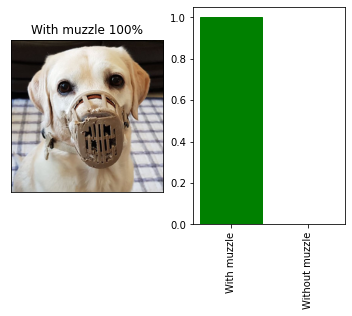

<Figure size 432x288 with 0 Axes>

In [163]:
img = Image.open('/home/dsl001/캡스톤 디자인/3.jpg')
resize = transfer_image(img)
pred_prob = model.predict(resize)
pred_label = get_pred_label(pred_prob)
plt.subplot(1, 2, 1)
plot_pred(pred_prob, img)
plt.subplot(1, 2, 2)
plot_pred_conf(pred_prob, pred_label)
plt.figure()

<Figure size 432x288 with 0 Axes>

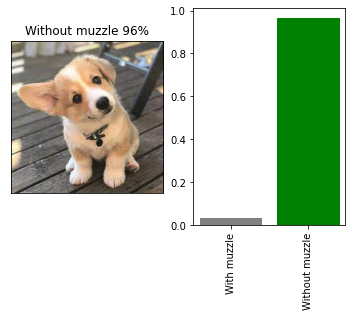

<Figure size 432x288 with 0 Axes>

In [164]:
img = Image.open('/home/dsl001/캡스톤 디자인/2.jpg')
resize = transfer_image(img)
pred_prob = model.predict(resize)
pred_label = get_pred_label(pred_prob)
plt.subplot(1, 2, 1)
plot_pred(pred_prob, img)
plt.subplot(1, 2, 2)
plot_pred_conf(pred_prob, pred_label)
plt.figure()